In [2]:
import numpy as np
import cv2
import glob
from math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
import scipy.misc

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

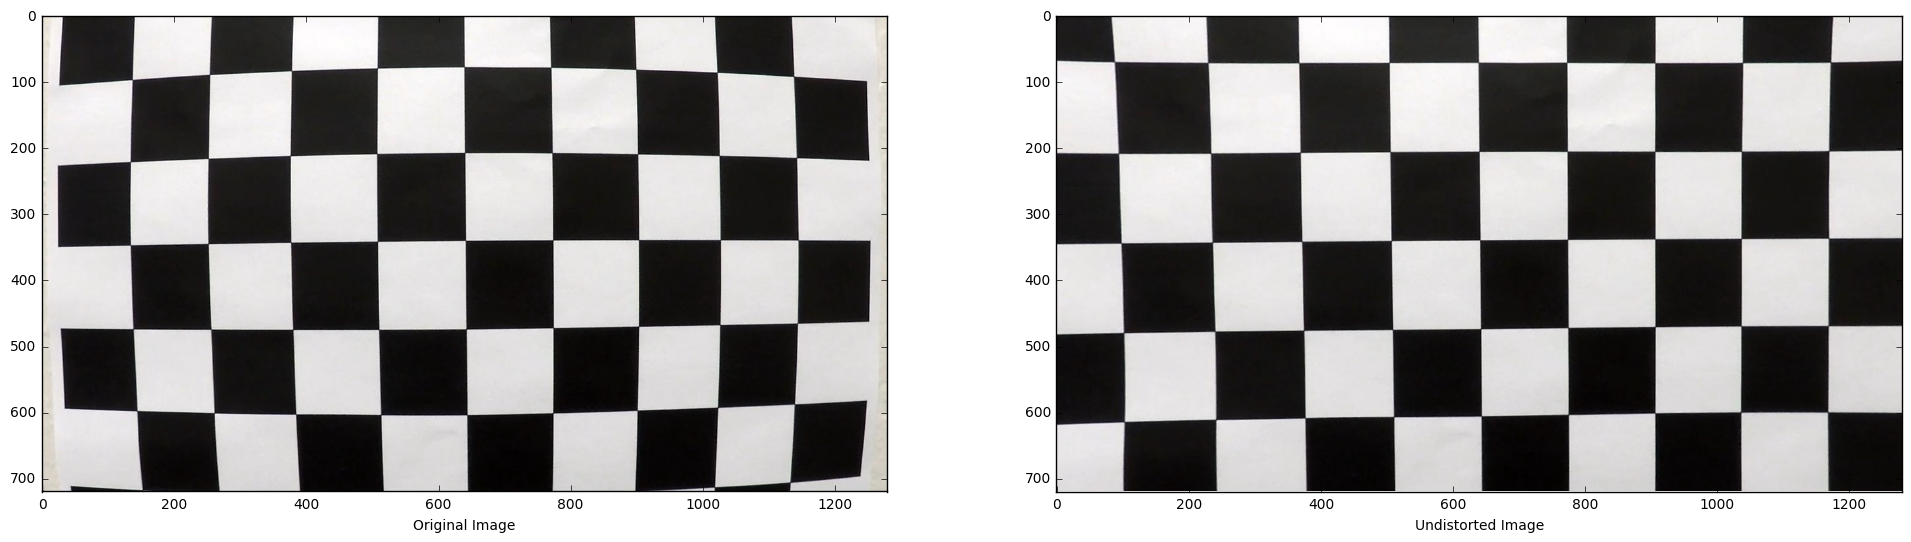

In [4]:
def calibrate_camera(cal_images, nx, ny):
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points
    objp = np.zeros((nx*ny,3), np.float32)
    # x, y coordinates
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    for image in cal_images:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        # If corners are found, add object points and image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist

def calibrate_images():
    cal_images = glob.glob('camera_cal/calibration*.jpg')
    # Provide number of inside corner for x and y
    nx, ny = 9, 6
    mtx, dist = calibrate_camera(cal_images, nx, ny)
    return mtx, dist

def undistort(img, mtx, dist):
    img_size = (img.shape[1], img.shape[0])
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


mtx, dist = calibrate_images()
image = mpimage.imread('camera_cal/calibration1.jpg')
# Undistort a test image
undist = undistort(image, mtx, dist)

plt.figure(figsize=(24,9))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(undist)
plt.xlabel('Undistorted Image')
plt.show()


### Apply a distortion correction to raw images

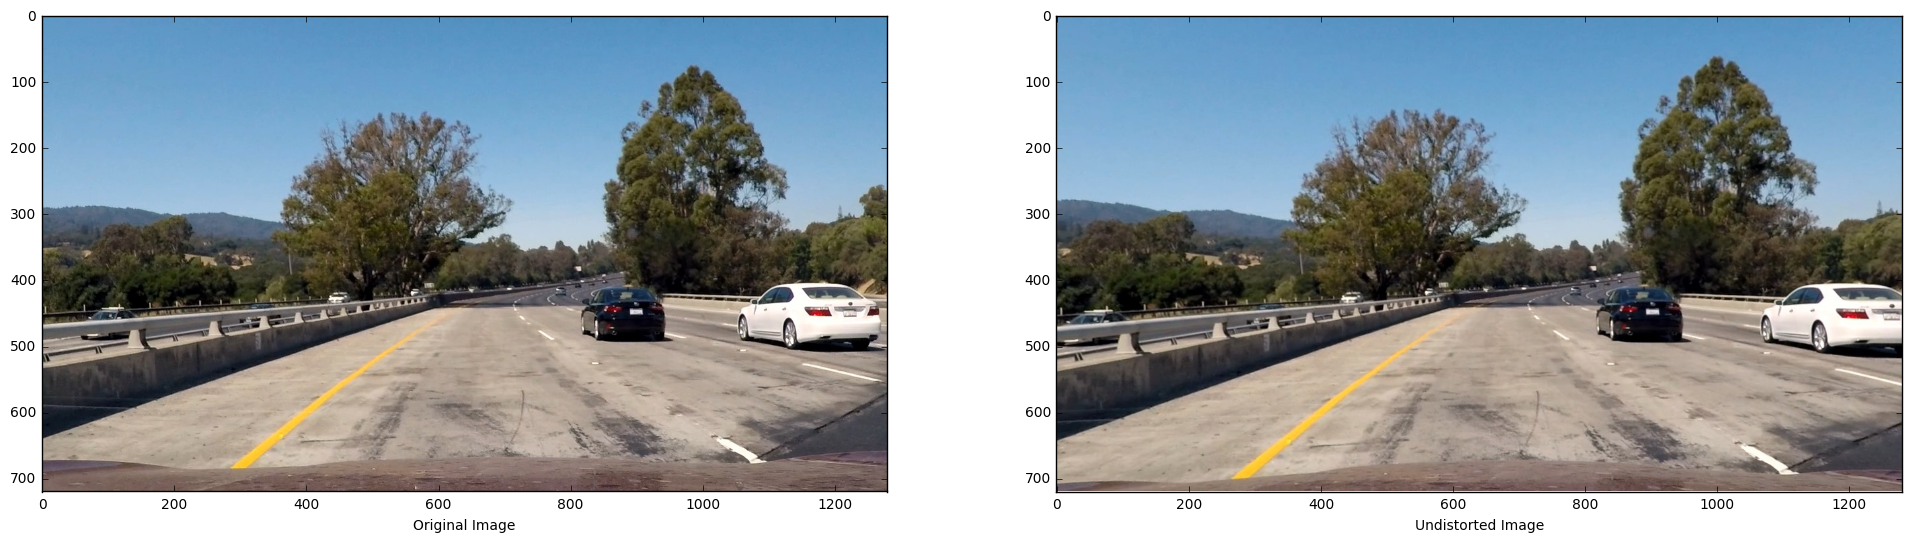

In [5]:
# Read in a test image and correct the distortion
image = mpimage.imread('test_images/test1.jpg')
# Undistort a test image
undist = undistort(image, mtx, dist)

plt.figure(figsize=(24,9))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.xlabel('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(undist)
plt.xlabel('Undistorted Image')
plt.show()

### Use color transforms, gradients, etc., to create a thresholded binary image

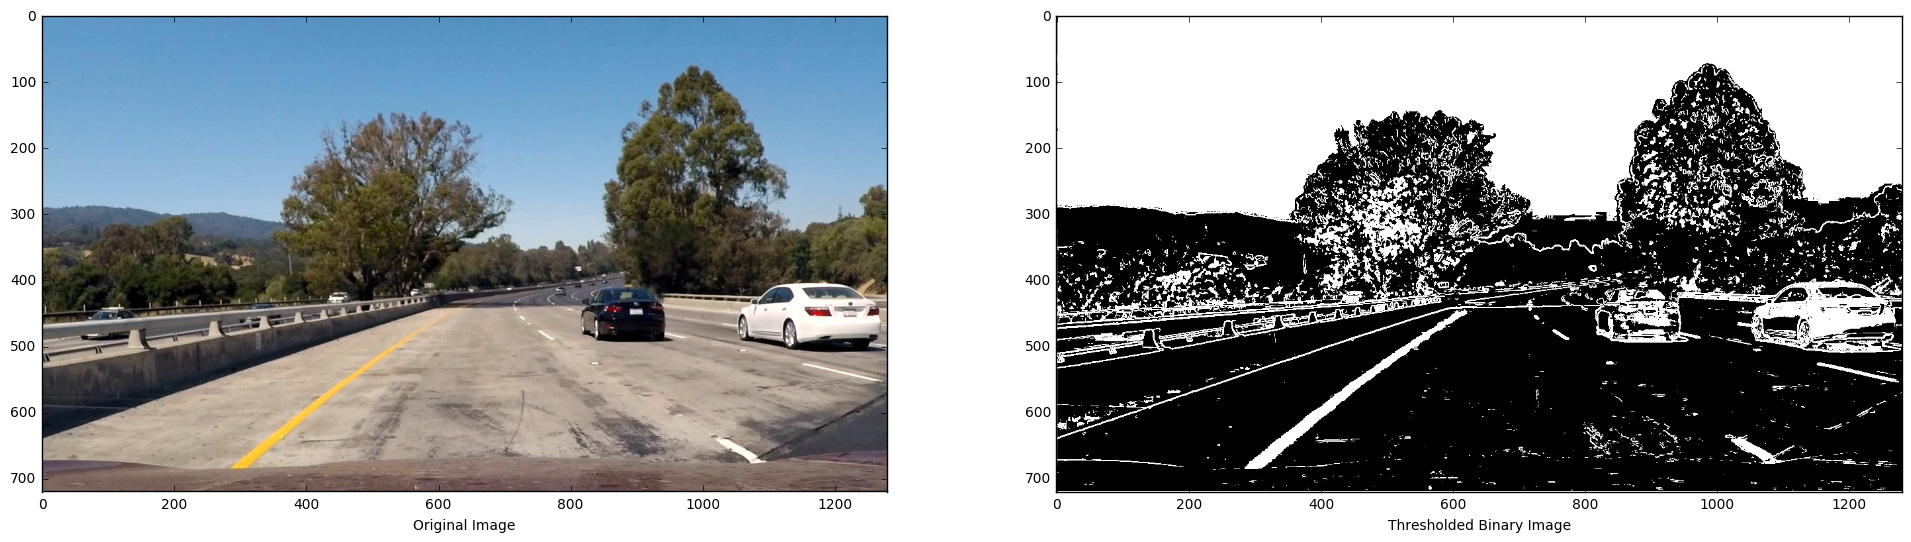

In [6]:
# Applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def abs_sobel_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output


# Applies color and gradient threshold
def thresholded_binary_image(image):
    # Apply color threshold
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    s_thresh_min = 100
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    ksize = 3 

    sxbinary = abs_sobel_thresh(image, 3, (40, 255))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1

    return combined_binary



test_image = mpimage.imread('test_images/test1.jpg')

combined = thresholded_binary_image(test_image)

plt.figure(figsize=(24,9))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.xlabel('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(combined, cmap='gray')
plt.xlabel('Thresholded Binary Image')
plt.show()

### Apply a perspective transform to rectify binary image ("birds-eye view")

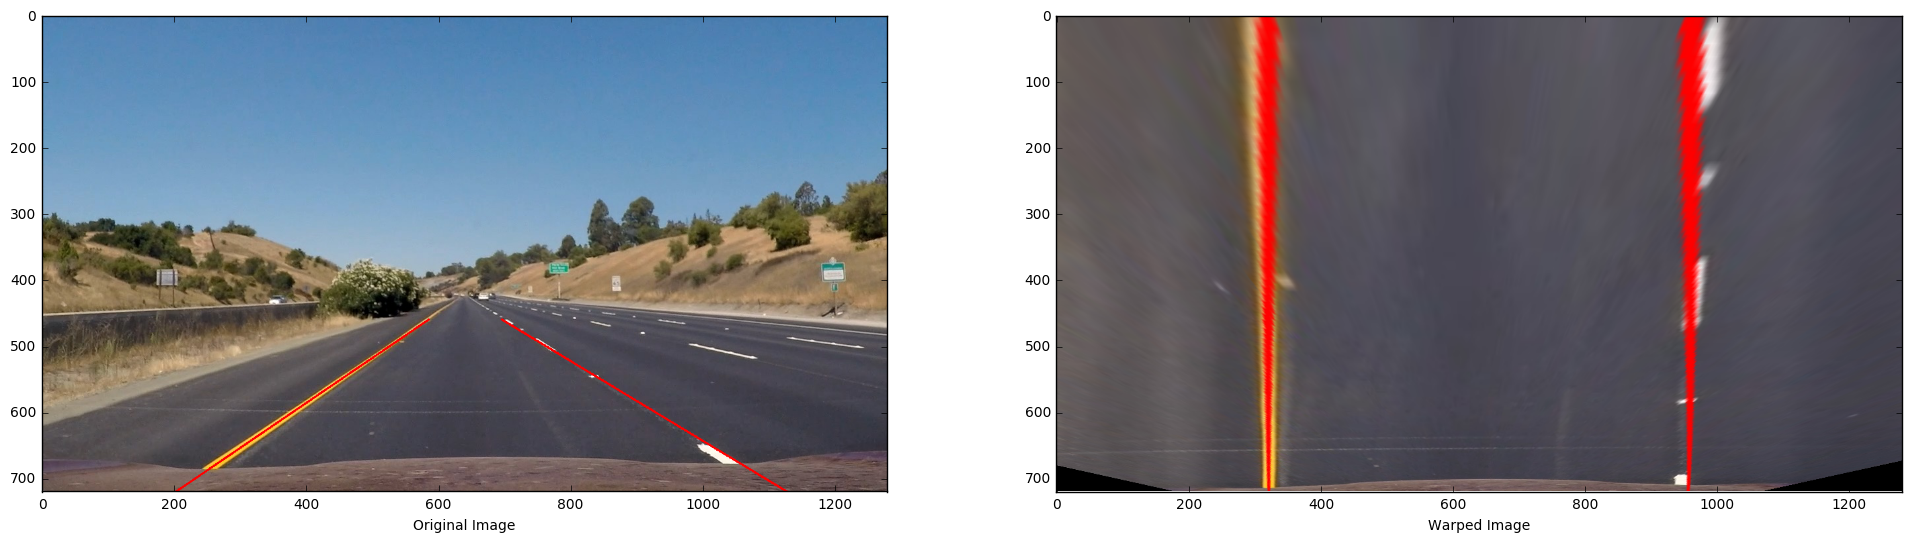

In [7]:
def transform_perspective(img, reverse = False):
    img_size = (img.shape[1], img.shape[0])
    image_width = image.shape[1]
    image_height = image.shape[0]
    
    
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
            
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
        
    if (reverse):
        src, dst = dst, src
        
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped

test_image = mpimage.imread('test_images/straight_lines1.jpg')


# Let's draw lines on source coordinates to visually confirm they are parallel in the destination image
cv2.line(test_image, \
         (585, 460), \
         (203, 720), \
         (255, 0, 0), 2)
cv2.line(test_image, \
         (1126, 720), \
         (695, 460), \
         (255, 0, 0), 2)

undistorted_img = undistort(test_image, mtx, dist)
warped = transform_perspective(undistorted_img)

plt.figure(figsize=(24,9))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.xlabel('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(warped, cmap='gray')
plt.xlabel('Warped Image')
plt.show()

### Detect lane pixels and fit to find the lane boundary.

In [8]:
def find_peaks(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Return x-position of the two peaks
    return leftx_base, rightx_base


def sliding_window(binary_warped, leftx_base, rightx_base, nwindows=10):
    # Choose the number of sliding windows
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each

    
    try: 
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        left_fit = None
        right_fit = None
        
        
    ''' # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)'''
    
    return left_fit, right_fit




### Determine the curvature of the lane and vehicle position with respect to center.

In [9]:
# Calculate the lane line curvature
def measure_curvature(ploty, leftx, rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval = np.max(ploty)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad



# Find the offset of the car and the base of the lane lines
def find_offset(l_poly, r_poly, height, width):
    lane_width = 3.7  #Lane width in the US is ~ 3.7 meters

    # Find the bottom pixel of the lane lines
    l_px = l_poly[0] * height ** 2 + l_poly[1] * height + l_poly[2]
    r_px = r_poly[0] * height ** 2 + r_poly[1] * height + r_poly[2]
    
    # Find the number of pixels per real metre
    scale = lane_width / np.abs(l_px - r_px)
    
    # Find the midpoint
    midpoint = np.mean([l_px, r_px])
    
    # Find the offset from the centre of the frame, and then multiply by scale
    offset = (width/2 - midpoint) * scale
    return offset




### Warp the detected lane boundaries back onto the original image.

In [10]:
# Plot the polygons on the image
def draw_polygon(ploty, fitl, fitr, orig):
    pts_left = np.array([np.transpose(np.vstack([fitl, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fitr, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    overlay = np.zeros_like(orig).astype(np.uint8)
    cv2.fillPoly(overlay, np.int_([pts]), (0,255, 0))
    
    # Apply inverse transform to the overlay to plot it on the original road
    newwarp = transform_perspective(overlay, reverse=True)
    
    # Add the overlay to the original unwarped image
    result = cv2.addWeighted(orig, 1, newwarp, 0.3, 0)
    return result


### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

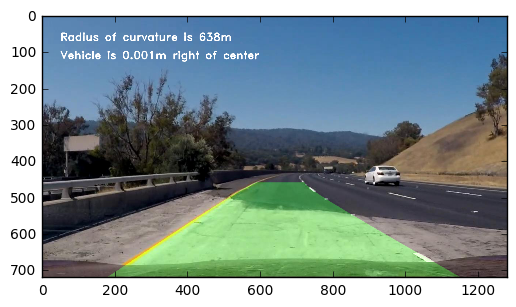

In [11]:
# Function to apply to frames of video
def pipeline(img, last_rad=None, last_l_poly=None, last_r_poly=None, frame_no=0):
    
    # Define weights for smoothing
    rad_alpha = 0.05
    poly_alpha = 0.2

    orig = img.copy()
    
    #if frame_no == 612:
    #    scipy.misc.imsave('test_images/' + str(frame_no) + '_outfile.jpg', orig)
    
    
    # Undistort given image
    undistorted_image = undistort(img, mtx, dist)
    
    # Obtain binary image
    combined = thresholded_binary_image(undistorted_image)
    
    # Change perspective for a given image
    mask = transform_perspective(combined)
    
    
    # Find initial histogram peaks
    left_peak, right_peak = find_peaks(mask)
    
    # Get the sliding window polynomials for each line
    l_poly, r_poly = sliding_window(mask, left_peak, right_peak)
    
    if (l_poly == None) or r_poly == None:
        return orig, last_rad, last_l_poly, last_r_poly, frame_no+1
    
    # Update polynomials using weighted average with last frame
    if last_l_poly is None:
        # If first frame, initialise buffer
        last_l_poly = l_poly
        last_r_poly = r_poly
    else:
        # Otherwise, update buffer
        l_poly = (1 - poly_alpha) * last_l_poly + poly_alpha * l_poly
        r_poly = (1 - poly_alpha) * last_r_poly + poly_alpha * r_poly
        last_l_poly = l_poly
        last_r_poly = r_poly
        
        
    # Convert polynomial to set of points for refitting
    ploty = np.linspace(0, mask.shape[0]-1, mask.shape[0])
    leftx = l_poly[0] * ploty ** 2 + l_poly[1] * ploty + l_poly[2]
    rightx = r_poly[0] * ploty ** 2 + r_poly[1] * ploty + r_poly[2]
        
    # Calculate the lane curvature radius
    left_curverad, right_curverad = measure_curvature(ploty, leftx, rightx)
    
    # Get mean of curvatures
    curverad = np.mean([left_curverad, right_curverad])
    
    # Update curvature using weighted average with last frame
    if last_rad is None:
        last_rad = curverad
    else:
        last_rad = (1 - rad_alpha) * last_rad + rad_alpha * curverad
        
    # Create image
    final_image = draw_polygon(ploty, leftx, rightx, orig)
        
    # Write radius on image
    cv2.putText(final_image, 'Radius of curvature is {}m'.format(int(last_rad)), (50, 70), cv2.FONT_HERSHEY_DUPLEX,  1,(255,255,255),2)

    # Write lane offset on image
    offset = find_offset(l_poly, r_poly, final_image.shape[0], final_image.shape[1])
   
    if offset < 0:
        text = "Vehicle is {:.3f}m left of center".format(-offset)
    else:
        text = "Vehicle is {:.3f}m right of center".format(offset)
    cv2.putText(final_image, text, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 1,(255,255,255),2)
    
    #scipy.misc.imsave('debug/' + str(frame_no) + '_outfile.jpg', final)

    
    frame_no += 1
    return final_image, last_rad, last_l_poly, last_r_poly, frame_no

test_image = mpimage.imread('test_images/612_outfile.jpg')

result, _, _, _, _ = pipeline(test_image)

# Output a test image
plt.imshow(result)


### Process project video

In [13]:
from moviepy.editor import VideoFileClip


# Buffer for retaining curvature and polygon information between frames
last_rad = None
last_l_poly = None
last_r_poly = None
frame_no = 0


def process_frame(image):
    
    global last_rad, last_l_poly, last_r_poly, frame_no
    result, last_rad, last_l_poly, last_r_poly, frame_no = pipeline(image,last_rad, last_l_poly, last_r_poly, frame_no)
    return result

def write_clip(input_file, output_file, function):
    clip = VideoFileClip(input_file)
    
    white_clip = clip.fl_image(function) #NOTE: this function expects color images!
    %time white_clip.write_videofile(output_file, audio=False)  
        
        
video_input = 'project_video.mp4'
video_output = 'project_video_solution.mp4'

write_clip(video_input, video_output, process_frame)


[MoviePy] >>>> Building video project_video_solution.mp4
[MoviePy] Writing video project_video_solution.mp4


100%|█████████▉| 1260/1261 [02:20<00:00,  9.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_solution.mp4 

CPU times: user 3min, sys: 32.5 s, total: 3min 32s
Wall time: 2min 20s


In [17]:
challenge_video_input = 'challenge_video.mp4'
challenge_video_output = 'challenge_video_solution.mp4'

write_clip(challenge_video_input, challenge_video_output, process_frame)

[MoviePy] >>>> Building video challenge_video_solution.mp4
[MoviePy] Writing video challenge_video_solution.mp4


100%|██████████| 485/485 [00:48<00:00,  9.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_solution.mp4 

CPU times: user 1min 4s, sys: 11.6 s, total: 1min 15s
Wall time: 49.3 s
